In [1]:
import akshare as ak
print("AkShare version:", ak.__version__)

AkShare version: 1.17.61


In [6]:
# 只抓取：上证A（fs = m:0 t:6）
# 行为：
# 1) 先探测 total（若失败也继续尽量下载）
# 2) 分页拉取，每页成功就立即写入 CSV（可续传）
# 3) 一旦出现接口限制/网络错误，立即保存已下数据 -> sleep(15s) -> 继续剩余页
# 4) 多轮抓取直到拿全或达到轮次上限；最终 CSV 去重合并

import os, time, math, random
import pandas as pd
import requests
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# -------- 可调参数 --------
CSV_PATH         = "/Users/zouxd/Documents/GitHub/MyTools/ak-tool-sh_a_snapshot.csv"   # 最终合并保存位置
PAGE_SIZE        = 200                   # 每页条数（100~500均可；越大越容易被限速，200较稳）
WAIT_SECONDS     = 15                    # 被限/出错后，等待再继续的秒数
ROUND_LIMIT      = 6                     # 最多尝试的轮数（每轮失败会等待后重试）
PER_PAGE_RETRY   = 3                     # 单页重试次数上限

# Eastmoney push2 备用域名（随机尝试，提升命中率）
HOSTS = [
    "https://push2.eastmoney.com/api/qt/clist/get",
    "https://82.push2.eastmoney.com/api/qt/clist/get",
    "https://32.push2.eastmoney.com/api/qt/clist/get",
]

FS_SH_A   = "m:0 t:6"         # 上证A
FIELDS    = "f12,f14"         # 只要 代码(f12) 和 名称(f14)，减小负载
COMMON_QS = {
    "po": "1",
    "np": "1",
    "ut": "bd1d9ddb04089700cf9c27f6f7426281",
    "fltt": "2",
    "invt": "2",
    "fid": "f12",
    "fs": FS_SH_A,
    "fields": FIELDS,
}

def make_session():
    s = requests.Session()
    retry = Retry(
        total=5, connect=5, read=5,
        backoff_factor=0.6,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
        raise_on_status=False,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://quote.eastmoney.com/",
        "Accept": "application/json, text/plain, */*",
    })
    return s

def read_existing(csv_path: str) -> pd.DataFrame:
    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path, dtype={"代码": str, "名称": str})
            # 统一列名
            if "代码" not in df.columns and "code" in df.columns:
                df = df.rename(columns={"code": "代码"})
            if "名称" not in df.columns and "name" in df.columns:
                df = df.rename(columns={"name": "名称"})
            df["代码"] = df["代码"].astype(str).str.strip()
            df["名称"] = df["名称"].astype(str).str.strip()
            df = df[["代码", "名称"]].drop_duplicates(subset=["代码"])
            return df
        except Exception:
            pass
    return pd.DataFrame(columns=["代码", "名称"])

def save_merged(csv_path: str, df_existing: pd.DataFrame, df_new: pd.DataFrame) -> pd.DataFrame:
    if not df_new.empty:
        merged = pd.concat([df_existing, df_new], ignore_index=True)
        merged = merged.drop_duplicates(subset=["代码"]).sort_values("代码")
    else:
        merged = df_existing.drop_duplicates(subset=["代码"]).sort_values("代码")
    merged.to_csv(csv_path, index=False)
    return merged

def get_total(session: requests.Session) -> int | None:
    """探测 total；失败时返回 None，不中断流程。"""
    params = dict(COMMON_QS)
    params.update({"pn": "1", "pz": "1"})
    for base in random.sample(HOSTS, k=len(HOSTS)):
        try:
            r = session.get(base, params=params, timeout=15)
            if r.status_code == 429:
                # 限流：返回 None，让上层走分页补抓逻辑
                return None
            r.raise_for_status()
            j = r.json()
            total = (j or {}).get("data", {}).get("total")
            if isinstance(total, int) and total > 0:
                return total
        except Exception:
            continue
    return None

def fetch_page(session: requests.Session, pn: int, pz: int) -> pd.DataFrame:
    """抓取指定页，返回 DataFrame(['代码','名称'])；失败抛异常。"""
    params = dict(COMMON_QS)
    params.update({"pn": str(pn), "pz": str(pz)})
    last_err = None
    for _ in range(PER_PAGE_RETRY):
        for base in random.sample(HOSTS, k=len(HOSTS)):
            try:
                r = session.get(base, params=params, timeout=15)
                if r.status_code == 429:
                    # 限速：抛出特定异常给上层处理
                    raise requests.HTTPError("429 Too Many Requests")
                r.raise_for_status()
                j = r.json()
                diff = (j or {}).get("data", {}).get("diff", []) or []
                rows = []
                for it in diff:
                    code = str(it.get("f12", "")).strip()
                    name = str(it.get("f14", "")).strip()
                    if code:
                        rows.append({"代码": code, "名称": name})
                return pd.DataFrame(rows, columns=["代码", "名称"])
            except Exception as e:
                last_err = e
                continue
    raise RuntimeError(f"fetch_page 失败：pn={pn}, pz={pz}, err={repr(last_err)}")

# ---------- 主流程 ----------
sess = make_session()
existing = read_existing(CSV_PATH)
print(f"已存在本地数据：{len(existing)} 条（{CSV_PATH}）")

total = get_total(sess)
if total:
    print(f"服务器报告总数：{total}（上证A）")
else:
    print("无法可靠获得 total，改为尽可能分页抓取（离线兜底继续）。")

# 若知道total就算总页数；否则设一个“乐观上限”，按常见规模 4000 给页数上限（会提前收敛）
pz = PAGE_SIZE
max_pages = math.ceil((total or 4000) / pz)

round_idx = 1
while round_idx <= ROUND_LIMIT:
    print(f"\n=== 第 {round_idx} 轮抓取开始 ===")
    failed = False
    new_rows_total = 0

    # 遍历页码
    for pn in range(1, max_pages + 1):
        # 如果已有 total 且已经拿够了，就提前结束
        if total and len(existing) >= total:
            print("已达到/超过总数，提前结束。")
            failed = False
            break

        # 小优化：如果 total 未知，当出现连续空页时提前结束
        try:
            df_page = fetch_page(sess, pn, pz)
        except Exception as e:
            print(f"第 {pn} 页失败：{e}")
            failed = True
            break

        if df_page.empty:
            print(f"第 {pn} 页为空。")
            # 如果连续空页，可能已经到末尾或被限流，视为本轮结束
            # 这里直接结束本轮，进入等待
            failed = True
            break

        # 合并并落盘（去重）
        before = len(existing)
        existing = save_merged(CSV_PATH, existing, df_page)
        added = len(existing) - before
        new_rows_total += max(0, added)

        print(f"第 {pn} 页：拿到 {len(df_page)} 条，新增加 {added} 条，累计 {len(existing)} 条。")

        # 若 total 未知，但 df_page 数量 < pz，可能到尾页，尝试提前结束一轮
        if not total and len(df_page) < pz:
            print("疑似尾页，结束本轮。")
            failed = False
            break

    # 轮次结束条件判断
    if not failed:
        # 若 total 已知且够了；或 total 未知但这一轮没有失败，认为完成
        if total and len(existing) >= total:
            print(f"\n✅ 完成：共 {len(existing)} 条（与 total {total} 基本一致）。已写入 {CSV_PATH}")
            break
        elif not total:
            # total 未知：如果这一轮没有失败，认为到达末尾
            print(f"\n✅ 完成（total 未知）：共 {len(existing)} 条。已写入 {CSV_PATH}")
            break

    # 如果失败了，等待再继续
    print(f"\n⚠️ 本轮未完成，已保存 {len(existing)} 条。等待 {WAIT_SECONDS}s 后继续剩余下载……")
    time.sleep(WAIT_SECONDS)
    round_idx += 1

# 最终落盘去重一次
existing = existing.drop_duplicates(subset=["代码"]).sort_values("代码")
existing.to_csv(CSV_PATH, index=False)
print(f"\n最终结果：{len(existing)} 条，上证A 代码/名称已保存到：{os.path.abspath(CSV_PATH)}")


已存在本地数据：0 条（/Users/zouxd/Documents/GitHub/MyTools/ak-tool-sh_a_snapshot.csv）
无法可靠获得 total，改为尽可能分页抓取（离线兜底继续）。

=== 第 1 轮抓取开始 ===
第 1 页失败：fetch_page 失败：pn=1, pz=200, err=ConnectionError(MaxRetryError("HTTPSConnectionPool(host='push2.eastmoney.com', port=443): Max retries exceeded with url: /api/qt/clist/get?po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&fid=f12&fs=m%3A0+t%3A6&fields=f12%2Cf14&pn=1&pz=200 (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))"))

⚠️ 本轮未完成，已保存 0 条。等待 15s 后继续剩余下载……

=== 第 2 轮抓取开始 ===
第 1 页失败：fetch_page 失败：pn=1, pz=200, err=ConnectionError(MaxRetryError("HTTPSConnectionPool(host='82.push2.eastmoney.com', port=443): Max retries exceeded with url: /api/qt/clist/get?po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&fid=f12&fs=m%3A0+t%3A6&fields=f12%2Cf14&pn=1&pz=200 (Caused by ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without respons

兴瑞科技(002937) 获取成功，复权口径：hfq，样本数：44


/var/folders/5h/zrph8_qn6v59j5ywg26y6v1c0000gp/T/ipykernel_98431/815789725.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  close_m = close_d.resample("M").last().dropna()
/var/folders/5h/zrph8_qn6v59j5ywg26y6v1c0000gp/T/ipykernel_98431/815789725.py:79: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
/var/folders/5h/zrph8_qn6v59j5ywg26y6v1c0000gp/T/ipykernel_98431/815789725.py:79: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
/var/folders/5h/zrph8_qn6v59j5ywg26y6v1c0000gp/T/ipykernel_98431/815789725.py:79: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
/var/folders/5h/zrph8_qn6v59j5ywg26y6v1c0000gp/T/ipykernel

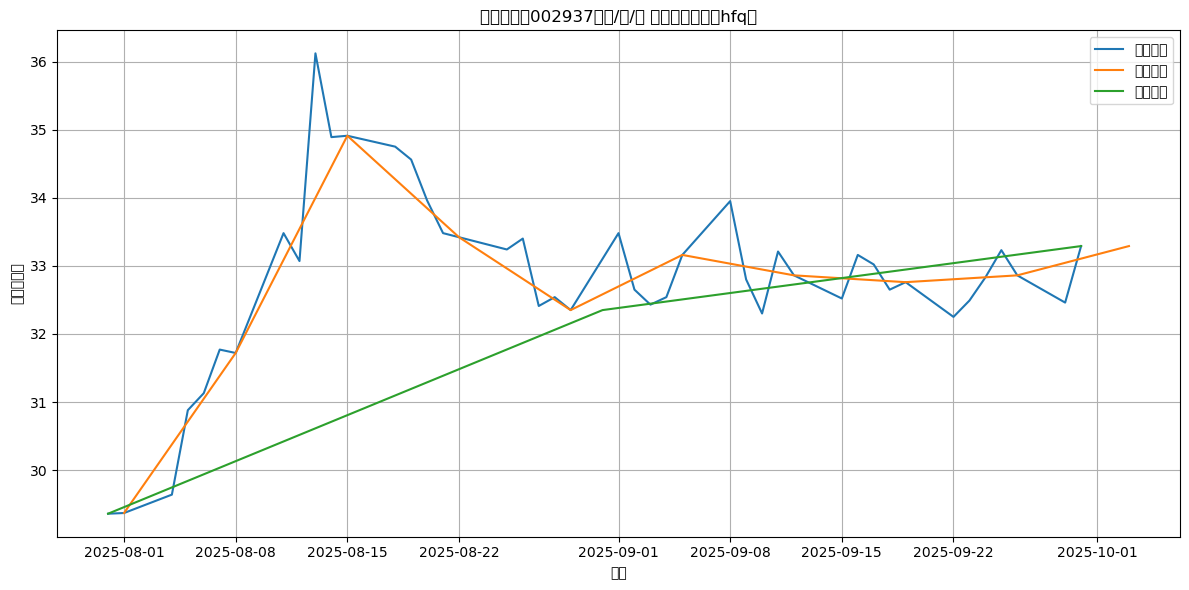

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def find_symbol_by_name(name: str) -> str:
    code_map = ak.stock_info_a_code_name()
    # 兼容不同列名
    if {"code","name"}.issubset(code_map.columns):
        code_col, name_col = "code", "name"
    elif {"证券代码","证券简称"}.issubset(code_map.columns):
        code_col, name_col = "证券代码", "证券简称"
    else:
        raise RuntimeError(f"无法识别代码/名称列: {list(code_map.columns)}")
    hit = code_map.loc[code_map[name_col] == name]
    if hit.empty:
        hit = code_map.loc[code_map[name_col].str.contains(name, na=False)]
    if hit.empty:
        raise RuntimeError(f"未找到股票：{name}")
    return str(hit.iloc[0][code_col]).strip()

def _standardize_cols(df: pd.DataFrame) -> pd.DataFrame:
    # 统一中英列名
    colmap = {
        "日期":"date","date":"date",
        "开盘":"open","open":"open",
        "最高":"high","high":"high",
        "最低":"low","low":"low",
        "收盘":"close","close":"close",
        "成交量":"volume","volume":"volume",
        "成交额":"amount","amount":"amount",
    }
    rename = {c:colmap.get(c,c) for c in df.columns}
    df = df.rename(columns=rename)
    if "date" not in df.columns or "close" not in df.columns:
        raise RuntimeError(f"缺少必要列: {list(df.columns)}")
    # 类型与索引
    df["date"] = pd.to_datetime(df["date"])
    for k in ["open","high","low","close","volume","amount"]:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce")
    df = df.sort_values("date").set_index("date")
    return df

def get_hist_clean(symbol: str, start="2018-01-01", end="2025-12-31", prefer="hfq") -> tuple[pd.DataFrame,str]:
    # 依次尝试 hfq -> qfq -> 不复权
    tried = []
    for adj in list(dict.fromkeys([prefer, "qfq", ""])):  # 去重保序
        tried.append(adj or "none")
        df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start.replace("-",""),
                                end_date=end.replace("-",""), adjust=adj)
        df = _standardize_cols(df)
        # 体检：剔除负价、全零
        bad_neg = ((df[["open","high","low","close"]] < 0).any(axis=1)).sum()
        if bad_neg > 0:
            # 该复权口径存在异常，尝试下一个
            continue
        all_zero = (df["close"] == 0).sum()
        if all_zero > 0:
            # 零价异常也视为不可用
            continue
        return df, (adj or "none")
    raise RuntimeError(f"所有口径均异常或不可用，已尝试：{tried}")

# ===== 示例：拿“兴瑞科技”，并画日/周/月同图 =====
name = "兴瑞科技"
symbol = find_symbol_by_name(name)
df_daily, used_adj = get_hist_clean(symbol, start="2025-07-31", end="2025-09-30", prefer="hfq")
close_d = df_daily["close"].dropna()
close_w = close_d.resample("W-FRI").last().dropna()
close_m = close_d.resample("M").last().dropna()

print(f"{name}({symbol}) 获取成功，复权口径：{used_adj}，样本数：{len(close_d)}")

plt.figure(figsize=(12,6))
plt.plot(close_d.index, close_d.values, label="日线收盘")
plt.plot(close_w.index, close_w.values, label="周线收盘")
plt.plot(close_m.index, close_m.values, label="月线收盘")
plt.title(f"{name}（{symbol}）日/周/月 收盘价（口径：{used_adj}）")
plt.xlabel("日期"); plt.ylabel("价格（元）")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [15]:
stock_szse_summary_df = ak.stock_szse_summary(date="20250930")
print(stock_szse_summary_df)

      证券类别     数量          成交金额           总市值          流通市值
0       股票   2914  1.209392e+12  4.272907e+13  3.695415e+13
1     主板A股   1485  6.248672e+11  2.491396e+13  2.266794e+13
2     主板B股     39  1.310946e+08  5.363816e+10  5.347689e+10
3    创业板A股   1390  5.843932e+11  1.776147e+13  1.423273e+13
4       基金    865  1.496688e+11  1.728982e+12  1.696746e+12
5      ETF    555  1.483785e+11  1.620279e+12  1.620279e+12
6      LOF    286  1.188309e+09  3.810333e+10  3.810333e+10
7    封闭式基金      0  0.000000e+00  0.000000e+00  0.000000e+00
8   基础设施基金     24  1.020030e+08  7.059897e+10  3.836350e+10
9       债券  16582  2.960731e+11           NaN           NaN
10    债券现券  15846  4.311659e+10  9.378751e+13  3.117899e+12
11    债券回购     27  2.515108e+11           NaN           NaN
12     ABS    709  1.445705e+09  4.805368e+11  4.805368e+11
13      期权    544  1.497629e+09           NaN           NaN


In [16]:

stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol="000001", period="daily", start_date="20250731", end_date='20250930', adjust="")
print(stock_zh_a_hist_df)

            日期    股票代码     开盘     收盘     最高     最低      成交量           成交额  \
0   2025-07-31  000001  12.51  12.23  12.55  12.22  1690081  2.079631e+09   
1   2025-08-01  000001  12.24  12.28  12.33  12.15  1012187  1.240239e+09   
2   2025-08-04  000001  12.24  12.30  12.38  12.21  1032690  1.271376e+09   
3   2025-08-05  000001  12.30  12.47  12.50  12.28  1132078  1.405152e+09   
4   2025-08-06  000001  12.47  12.46  12.52  12.40   690448  8.596847e+08   
5   2025-08-07  000001  12.44  12.47  12.53  12.39   722053  9.007600e+08   
6   2025-08-08  000001  12.48  12.40  12.53  12.39   829796  1.032587e+09   
7   2025-08-11  000001  12.40  12.30  12.42  12.27   934353  1.150305e+09   
8   2025-08-12  000001  12.30  12.33  12.40  12.30   680056  8.396356e+08   
9   2025-08-13  000001  12.37  12.26  12.40  12.23  1119813  1.376778e+09   
10  2025-08-14  000001  12.27  12.20  12.34  12.19  1241041  1.523448e+09   
11  2025-08-15  000001  12.23  12.08  12.23  11.94  1948503  2.344073e+09   